In [64]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
from scipy import optimize

# Graphing Zero Data #

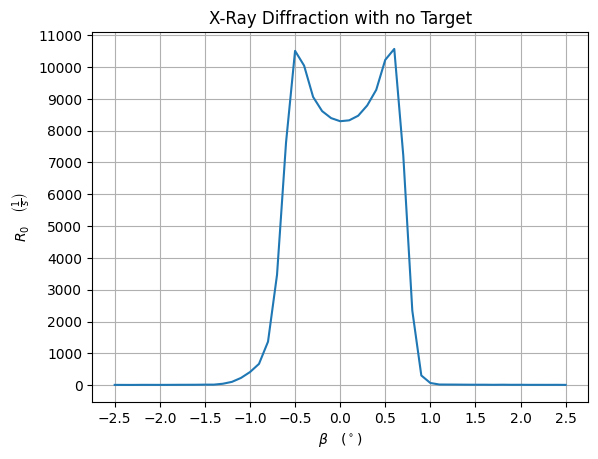

In [65]:
data1 = pandas.read_csv('ZeroData.csv')
beta = np.array(data1['angle'])
R_0 = np.array(data1['rate'])
xticksize = 0.5
yticksize = 1000
plt.xticks(np.arange(min(beta), max(beta)+xticksize, xticksize))
plt.yticks(np.arange(round(min(R_0)/yticksize)*yticksize, max(R_0)+yticksize, yticksize))
plt.xlabel(r"$\beta \quad (^\circ)$")
plt.ylabel(r"$R_0\quad \left(\frac{1}{s}\right)$")
plt.title(r"X-Ray Diffraction with no Target")
plt.grid(visible = True)
plt.plot(beta, R_0)
plt.savefig('../Graphs/ZeroData.png')

# Graphing Full Data #

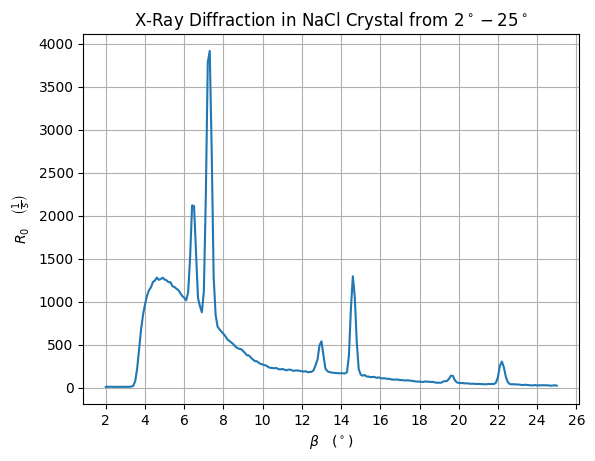

In [66]:
data1 = pandas.read_csv('FullData.csv')
beta = np.array(data1['angle'])
R_0 = np.array(data1['rate'])
xticksize = 2
yticksize = 500
plt.xticks(np.arange(min(beta), max(beta)+xticksize, xticksize))
plt.yticks(np.arange(round(min(R_0)/yticksize)*yticksize, max(R_0)+yticksize, yticksize))
plt.xlabel(r"$\beta \quad (^\circ)$")
plt.ylabel(r"$R_0\quad \left(\frac{1}{s}\right)$")
plt.title(r"X-Ray Diffraction in NaCl Crystal from $2^\circ-25^\circ$")
plt.grid(visible = True)
plt.plot(beta, R_0)
plt.savefig('../Graphs/FullData.png')

# Fitting Each Peak #

In [67]:
def fitSideBands(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def getSideBands(beta, R_0, peakRange):
    sideBand_beta = beta
    sideBand_R_0 = R_0
    for i in range(len(beta)):
        if(beta[i] < peakRange[1] and beta[i] > peakRange[0]):
            sideBand_beta = np.delete(sideBand_beta, np.where(sideBand_beta == beta[i])[0])
            sideBand_R_0 = np.delete(sideBand_R_0, np.where(sideBand_R_0== R_0[i])[0])
    return sideBand_beta, sideBand_R_0

def findPeakCenter(angle, rate, peakBounds, peakNumber = 0, peakTitle = "", noPlot = False):
    
    ## Fits to data and calculates the center of 
    bg_angle, bg_rate = getSideBands(angle, rate, peakBounds)# Determines background from given peak bounds
    bg_rate_uncertainty = np.sqrt(bg_rate*20)
    rate_uncertainty = np.sqrt(rate*20)
    backgroundParams, backgroundCovariance = optimize.curve_fit(fitSideBands, bg_angle, bg_rate, sigma = bg_rate_uncertainty, absolute_sigma=True) # Fits a cubic to the calculated background data
    def fitPeak(x, a, b, c):
        return a*np.exp(-(x-b)**2/c**2) + fitSideBands(x, *backgroundParams)
    peakParams, peakCovariance = optimize.curve_fit(fitPeak, angle, rate, p0 = [max(rate), angle[int(len(angle)/2)], .2], sigma = rate_uncertainty, absolute_sigma=True) # Fits a gaussian to the peak added to the background fit
    mu = peakParams[1] # Calculated center of peak
    delta_mu= np.sqrt(np.diag(peakCovariance)[1]) # Calculated error in mu
    if(noPlot):
        return mu, delta_mu
    
    ## Creates Plot
    delta_mu = printChSq(angle, rate, peakBounds)
    plt.plot(angle, rate, "b.", label = "Collected Data")
    plt.errorbar(angle, rate,fmt = "b.", yerr = rate_uncertainty/5, xerr = .025)
    xmin, xmax = plt.gca().get_xlim()
    angle_range = np.linspace(xmin, xmax, 1000)
    plt.plot(angle_range, fitPeak(angle_range, *peakParams), "g-", label = "Fitted Curve")
    plt.xlabel(r"$\beta \quad (^\circ)$")
    plt.ylabel(r"Rate of Counts (1/s)")
    ymin, ymax = plt.gca().get_ylim()
    xticksize = 0.2
    plt.xticks(np.arange(min(angle)-2*xticksize, max(angle)+2*xticksize, xticksize))    
    plt.vlines(mu, ymin, ymax, "tab:orange", label = r"$\mu = {mu:.2f}^\circ\pm {delta:.5f}^\circ$".format(mu= mu, delta =delta_mu), ls = '--')
    plt.title(peakTitle)
    plt.grid(visible = True)
    plt.legend()
    plt.savefig('../Graphs/Peak {}.png'.format(peakNumber))
    plt.show()
    return mu, delta_mu


def printChSq(angle, rate, peakBounds):
    mu, sigma_mu = findPeakCenter(angle, rate, peakBounds, noPlot = True)
    cur_mu = mu
    def fitPeak(x, a, c):
        return a*np.exp(-(x-cur_mu)**2/c**2) + fitSideBands(x, *backgroundParams)
    bg_angle, bg_rate = getSideBands(angle, rate, peakBounds)# Determines background from given peak bounds
    bg_rate_uncertainty = np.sqrt(bg_rate*20)
    rate_uncertainty = np.sqrt(rate*20)
    backgroundParams, backgroundCovariance = optimize.curve_fit(fitSideBands, bg_angle, bg_rate, sigma = bg_rate_uncertainty, absolute_sigma=True) # Fits a cubic to the calculated background data
    peakParams, peakCovariance, peakDict, mesg, ief = optimize.curve_fit(fitPeak, angle, rate, p0 = [max(rate), .2], sigma = rate_uncertainty, full_output=True, absolute_sigma=True)
    peakchsq = np.sqrt(sum(peakDict.get('fvec')**2))
    chsq  = 0
    while(chsq <= peakchsq+1):
        peakParams, peakCovariance, peakDict, mesg, ief = optimize.curve_fit(fitPeak, angle, rate, p0 = [max(rate), .2], sigma = rate_uncertainty, full_output=True, absolute_sigma=True)
        chsq = np.sqrt(sum(peakDict.get('fvec')**2))
        cur_mu+=sigma_mu/100
    return cur_mu-mu
    

### Peak 1 ###

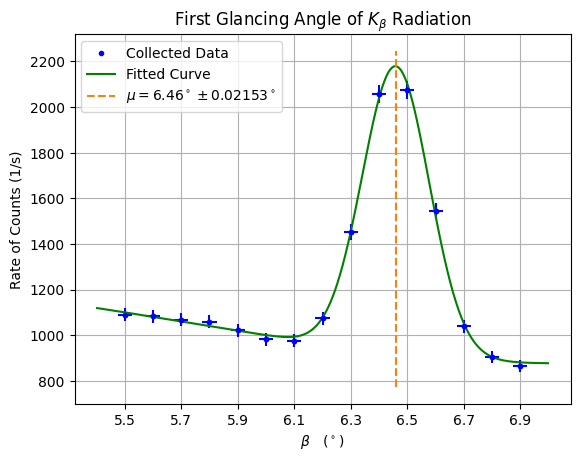

(6.459171591506704, 0.021532032239084842)

In [68]:
data1 = pandas.read_csv('Peak 1.csv')

angle1 = np.array(data1['angle'])
angle1 = angle1[:-6]


rate1 = np.array(data1['rate'])
rate1= rate1
rate1 = rate1[:-6]

findPeakCenter(angle1, rate1, [6.1, 6.8], 1, r"First Glancing Angle of $K_\beta$ Radiation")

### Peak 2

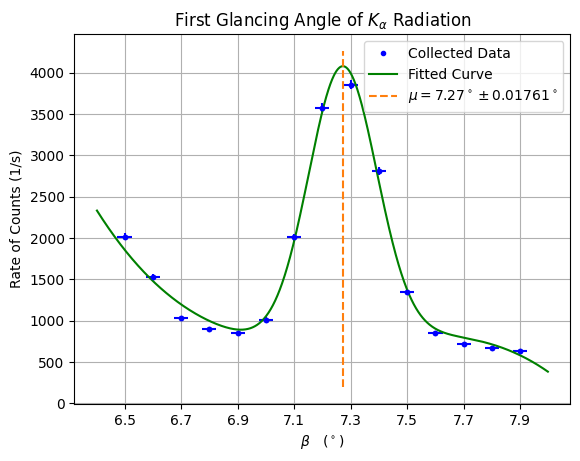

(7.2714996258045685, 0.01760949658042943)


In [69]:
data2 = pandas.read_csv('Peak 2.csv')

angle2 = np.array(data2['angle'])
angle2 = angle2[:-6]

rate2 = np.array(data2['rate'])
rate2 = rate2[:-6]

print(findPeakCenter(angle2, rate2, [7.0, 7.6], 2, r"First Glancing Angle of $K_\alpha$ Radiation"))

### Peak 3

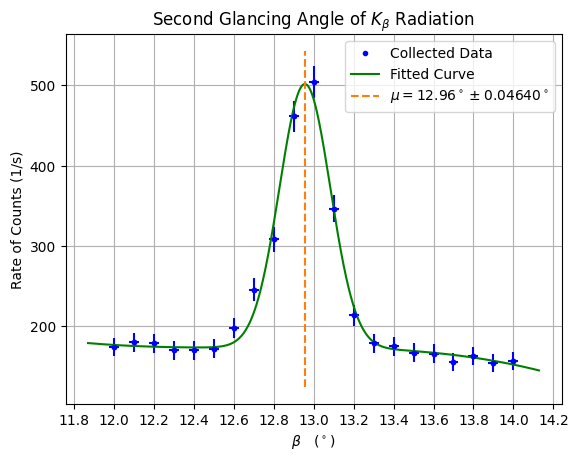

(12.956934868664154, 0.046398184620185745)


In [70]:
data3 = pandas.read_csv('Peak 3.csv')

angle3 = np.array(data3['angle'])
#angle3 = angle3[:-6]

rate3 = np.array(data3['rate'])
#rate3 = rate3[:-6]

print(findPeakCenter(angle3, rate3, [12.5, 13.3], 3, r"Second Glancing Angle of $K_\beta$ Radiation"))

### Peak 4

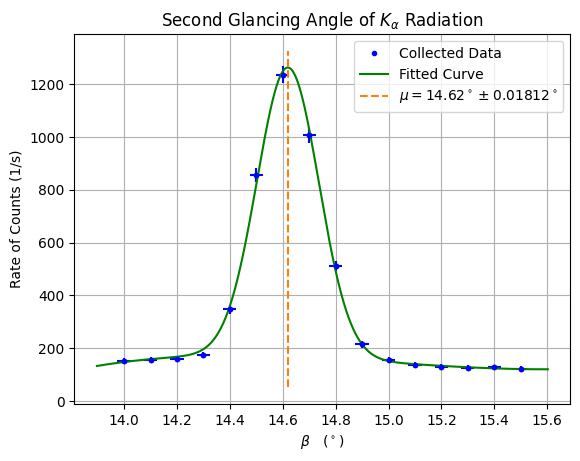

(14.619681060768821, 0.018121127937890336)


In [71]:
data4 = pandas.read_csv('Peak 4.csv')

angle4 = np.array(data4['angle'])
#angle4 = angle3[:-6]

rate4 = np.array(data4['rate'])
#rate4 = rate3[:-6]

print(findPeakCenter(angle4, rate4, [14.3, 15.0], 4, r"Second Glancing Angle of $K_\alpha$ Radiation"))

### Peak 5

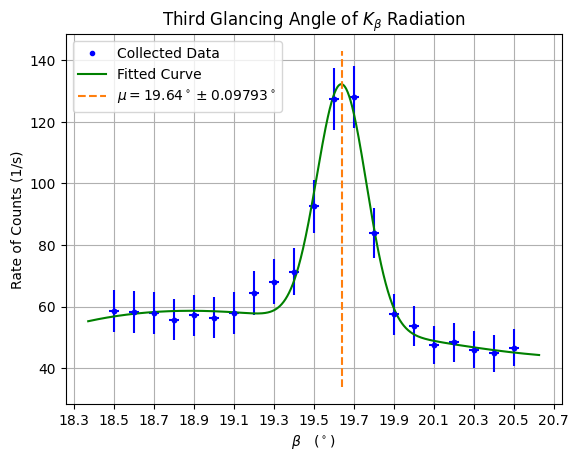

(19.640230247203686, 0.09793017426468964)


In [74]:
data5 = pandas.read_csv('Peak 5.csv')

angle5 = np.array(data5['angle'])
#angle5 = angle5[:-6]

rate5 = np.array(data5['rate'])
#rate3 = rate3[:-6]

print(findPeakCenter(angle5, rate5, [19.2, 20.1], 5, r"Third Glancing Angle of $K_\beta$ Radiation"))

### Peak 6

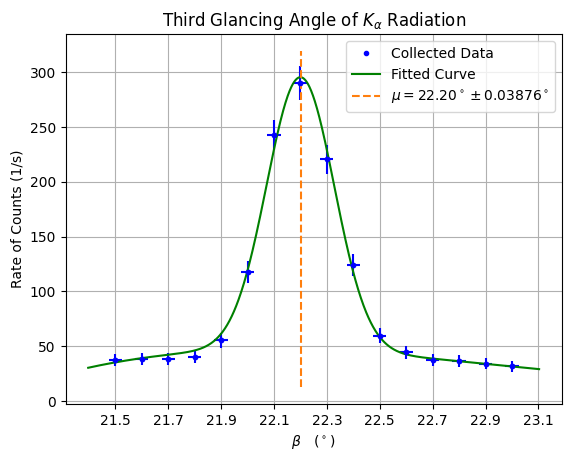

(22.200307861340917, 0.03875609836224925)


In [75]:
data6 = pandas.read_csv('Peak 6.csv')

angle6 = np.array(data6['angle'])
#angle3 = angle3[:-6]

rate6 = np.array(data6['rate'])
#rate3 = rate3[:-6]

print(findPeakCenter(angle6, rate6, [21.9, 22.7], 6, r"Third Glancing Angle of $K_\alpha$ Radiation"))